## Introduction

You are working as an ML engineer in Visiemo, a famous sound-based sentiment analysis company. It’s Monday morning and you are chilling at the coffee machine with fellow Visiumees. Suddenly, the AI project manager schedules you a project kick-off meeting. A multinational client is interested in our services: the client has different call centers around the world and would like to analyze the satisfaction of its customers based on the recordings of the calls.

The client has heard about AI and Visiemo, more precisely about our expertise in sentiment analysis.
However,the client is reluctant in whether the solution will work. As such, it has been agreed to first do a proof-of-concept on the call centers from Germany.

At Visiemo, we have decided to use an already existing dataset and design a small proof-of-concept to showcase the solution to the client.

## Instructions

In the frame of this use-case, you will be confronted to **Speech Emotion Recognition** with the **Emo-DB** dataset. The goal is to design a proof-of-concept model which classifies samples of emotional speech in one of the given emotions.

By the end of the use-case, you should have a working model with good enough performance, fairly evaluated. 

*We do not aim to have the best performing model.* On the contrary, you should aim for an end-to-end working solution that enables inference on new speech samples.

* As a **report**, you should fill in the present notebook.
* You should dockerize your project. The **Docker container** should handle everything (download the data, run the code, etc.). When running the container **it should expose the Jupyter notebook on one port and expose a Flask API on another one**.
* The **Flask API** should contain two endpoints:
  - One for training the model
  - One for querying the last trained model with an audio file of our choice in the dataset
* The code that you will develop should be **entirely reproducible** and **documented in a README.md file**.

## Final presentation

* The final presentation will be held on-site or remotely depending on your availability. 
* An AI Project Manager and two ML engineers will be present. 
* You will start by giving a 10-15 min technical presentation about your approach and your findings, using the slides provided as deliverables. Finally, a discussion with questions of about 20 min will follow.
* It should be clear enough to understand your approach and your decisions without going too much in the code. 
* You can also include code snippets, demos, etc.

## Important points to keep in mind

* Please be aware that this use-case might take a substantial amount of time, especially if you are not familiar with all the tools.
* You will have one full week to tackle the problem, starting today. We broadly estimate to *15-20 hours* the usual development time needed.
* Don’t spend too much time finding the perfect technical solution or making tiny metric improvements. 
* If you don't manage to finish all the tasks, you can still send us your use-case: we will discuss the difficulties you encountered during the final presentation.
* **Do not upload your code to Github, or at least not in a public repo.**
* Feel free to use any available library you would need, but **do not re-use someone else's code without mentioning it.**

## Deliverables 

Please provide the following elements in a **.zip** file as deliverables:
* This report filled with your approach, in the form of an **iPython Notebook**.
* A **5-10 slides PDF file**, containing a technical presentation covering the important aspects of your work.
* A **Dockerfile** defining a container for the project expositing the present notebook and the Flask API.
* A **README.md** which should contain the commands to build and run the docker container, as well as how to perform the queries to the API. 
* **Any** necessary .py, .sh or other files needed to run your code.

You will be judged on your technical approach, evaluation, visualizations, coding and presentation skills.

## About the data

The dataset can be found [here](http://emodb.bilderbar.info/index-1280.html).

It contains samples of emotional speech in German, labeled with one of 7 different emotions: Anger, Boredom, Disgust, Fear, Happiness, Sadness and Neutral. 

Please download the full database and refer to the documentation to understand how the samples are labeled (see "Additional information").

# Libraries Loading

In [1]:
from os import listdir, getcwd
from os.path import join, dirname
import pandas as pd
import librosa

from src import formatData
from src import plot_audio
from src import extractFeatures
from src import evaluation

# Data Preparation & Cleaning

### Data Loading

In [2]:
PATH_DATA = join(getcwd(), 'download', 'wav')

data = formatData.createDataFrame(PATH_DATA)

data.head(5)

,id,user_id,text_id,label,versions,emotion,ts,sr,len_ts
0,16a02Lb,16,a02,L,b,boredom,"[0.00124133, 0.0010521726, 0.0004256508, 0.000...",22050,45889
1,14a07Wc,14,a07,W,c,anger,"[6.805249e-06, 1.2503062e-05, -3.899378e-05, -...",22050,45501
2,10a07Ad,10,a07,A,d,fear,"[0.0011187387, 0.0011917101, 0.0005759509, -0....",22050,35355
3,13a05Ea,13,a05,E,a,disgust,"[0.0014452776, 0.0008329833, -0.0003924449, -0...",22050,92521
4,14a05Wa,14,a05,W,a,anger,"[0.0003161473, 0.00027575556, 3.9782277e-05, -...",22050,88351


### EDA

In [3]:
import numpy as np

print(f'There are {data.shape[0]} recordings')
print(f'There are {len(np.unique(data.loc[:,"user_id"]))} different users')
print(f'There are {len(np.unique(data.loc[:,"text_id"]))} different text id')


There are 535 recordings
There are 10 different users
There are 10 different text id


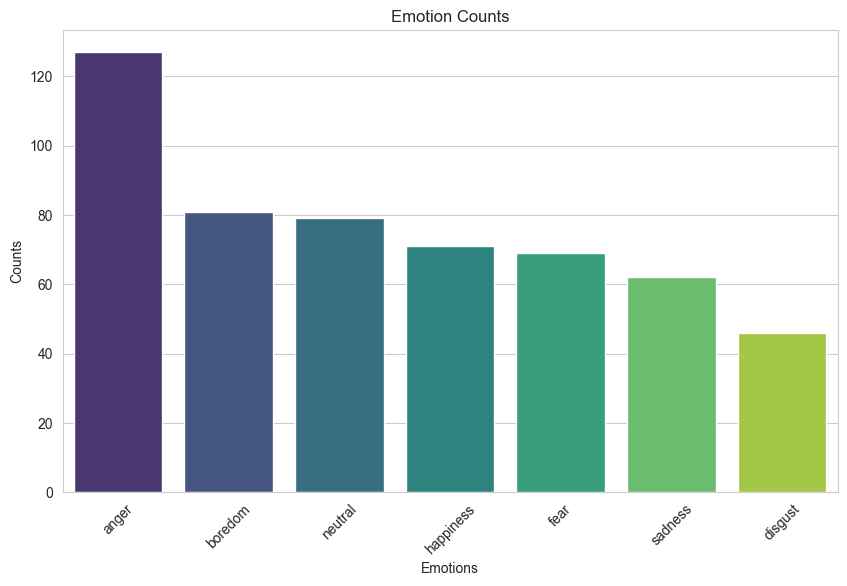

In [4]:
import matplotlib.pyplot as plt
import seaborn as sns

emotions = ['anger', 'boredom', 'disgust', 'fear', 'happiness', 'neutral', 'sadness']
counts = [127, 81, 46, 69, 71, 79, 62]

sorted_data = sorted(zip(emotions, counts), key=lambda x: x[1], reverse=True)
sorted_emotions, sorted_counts = zip(*sorted_data)

sns.set_style("whitegrid")  # Set the style of the plot
plt.figure(figsize=(10, 6))  # Set the size of the plot

# Create the bar plot
sns.barplot(x=list(sorted_emotions), y=list(sorted_counts), palette='viridis')

# Set the labels and title
plt.xlabel('Emotions')
plt.ylabel('Counts')
plt.title('Emotion Counts')

# Rotate the x-axis labels if needed
plt.xticks(rotation=45)

# Show the plot
plt.show()

### Visualize Time Series

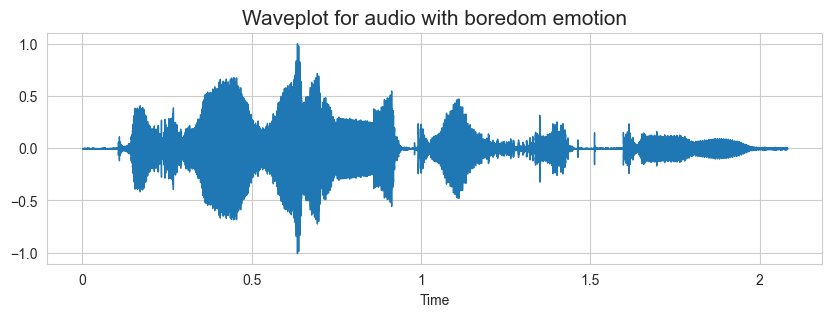

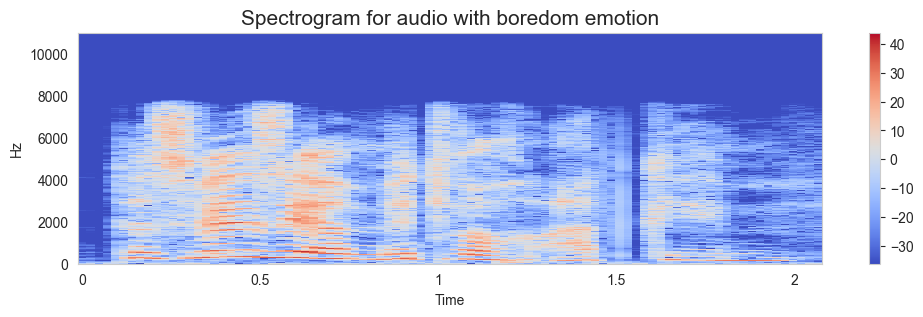

In [5]:
ts = data.loc[0, 'ts']
sr = data.loc[0, 'sr']


plot_audio.create_waveplot(ts, sr, 'boredom')
plot_audio.create_spectrogram(ts, sr, 'boredom')

## Divide Train Test

3 users to test

In [6]:
import random
from sklearn.utils import shuffle

def splitTrainTestByUser(data: pd.DataFrame, test_size:float = 0.2, random_state:int = 42):
    users = np.unique(data.loc[:,'user_id'].values.tolist())
    num_test = int(len(users)*test_size)

    random.seed(random_state)
    users_test = random.sample(list(users), num_test)

    train = data.loc[~data.loc[:,'user_id'].isin(users_test),]
    test = data.loc[data.loc[:,'user_id'].isin(users_test),]

    return shuffle(train), shuffle(test)


In [7]:
train, test = splitTrainTestByUser(data)

# Feature Engineering & Modeling

### Features

* Zero Cross Rate
* Energy
* Entropy of Energy
* Spectral Centroid
* Spectral Spread
* Spectral Entropy
* Spectral Flux
* Spectral Roll off
* MFCC
* Chroma Vector
* Chroma Deviation


Fisher test

In [8]:
train

,id,user_id,text_id,label,versions,emotion,ts,sr,len_ts
273,09b03Lb,09,b03,L,b,boredom,"[0.00043275792, 9.153162e-05, 0.00020812622, 0...",22050,86392
163,14b10Tc,14,b10,T,c,sadness,"[0.016461655, 0.019214682, 0.017389102, 0.0191...",22050,75223
398,13b10Ec,13,b10,E,c,disgust,"[-0.0038286122, -0.004565742, -0.0039602974, -...",22050,62793
52,09a01Wb,09,a01,W,b,anger,"[3.1683685e-05, 8.180914e-05, 8.455546e-05, 5....",22050,37519
502,13b01Ld,13,b01,L,d,boredom,"[0.00024472747, 0.00035642638, 0.000339734, 0....",22050,58958
...,...,...,...,...,...,...,...,...,...
390,15a04Ab,15,a04,A,b,fear,"[0.0045252223, 0.0062505305, 0.005061191, 0.00...",22050,40345
315,10a04Wb,10,a04,W,b,anger,"[5.0601346e-05, -4.006535e-05, -0.00013972726,...",22050,39941
157,16a01Lb,16,a01,L,b,boredom,"[-0.00097332767, -0.0012577174, -0.0014703698,...",22050,44841
46,14b02Wd,14,b02,W,d,anger,"[5.6371526e-05, 6.9196714e-05, 5.2202988e-05, ...",22050,50546


In [9]:
code_emotions = {'W': 'anger', 'L':'boredom', 'E':'disgust', 'A':'fear',
                'F':'happiness', 'T':'sadness', 'N':'neutral'}
label2int = {'N':0, 'A':1, 'E':2, 'F':3, 'L':4, 'T':5, 'W':6}
emotion2int = {'neutral':0, 'fear':1, 'disgust':2, 'happiness':3, 'boredom':4, 'sadness':5, 'anger':6}

In [10]:
from src.extractFeatures import FeatureExtractor

extractFeatures = FeatureExtractor()

X_train = np.apply_along_axis(lambda x: extractFeatures(x[0], x[1]), axis=1, arr=np.array(train.loc[:,['ts', 'sr']].values))
y_train = train.loc[:,'label'].apply(lambda x: label2int[x]).values

X_test = np.apply_along_axis(lambda x: extractFeatures(x[0], x[1]), axis=1, arr=np.array(test.loc[:,['ts', 'sr']].values))
y_test = test.loc[:,'label'].apply(lambda x: label2int[x]).values

### Anova Feature Selection

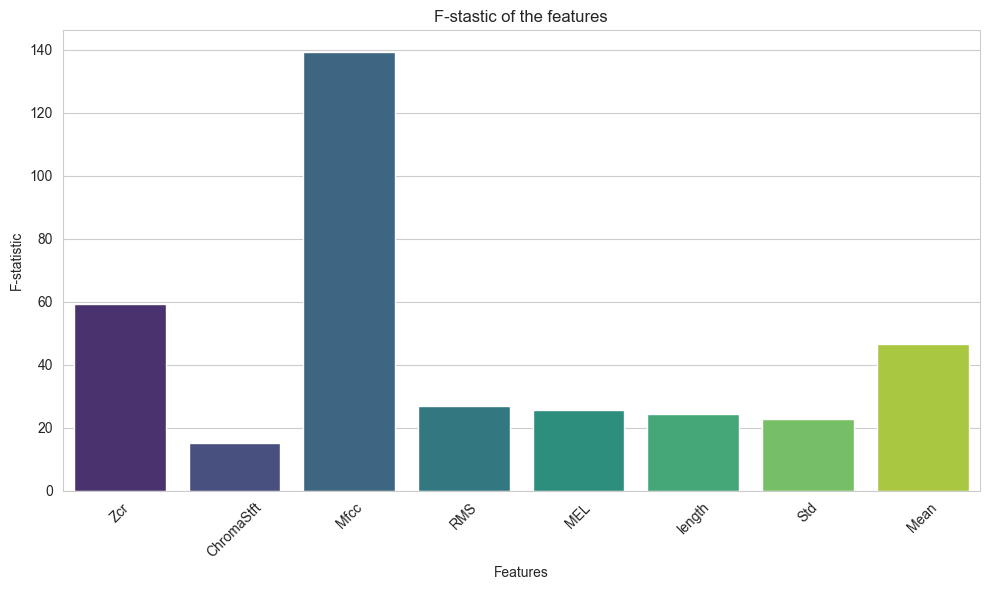

In [11]:
feature_names = extractFeatures.features

from sklearn.feature_selection import f_classif
f_value = f_classif(X_train, y_train)


plt.figure(figsize=(10, 6))
sns.barplot(x=feature_names, y=f_value[0], palette="viridis")
plt.xlabel('Features')
plt.ylabel('F-statistic')
plt.title('F-stastic of the features')
plt.xticks(rotation=45)
plt.tight_layout()

# Display the plot

### Define model

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler, MinMaxScaler, RobustScaler, LabelEncoder
from sklearn.linear_model import LogisticRegression
import xgboost as xgb


models = {}

models['LGR'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', LogisticRegression(class_weight='balanced'))
])

models['RFC_50'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=50, oob_score=True, class_weight='balanced'))
])

models['RFC_100'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=100, oob_score=True, class_weight='balanced'))
])

models['RFC_200'] = Pipeline([
    ('scaler', StandardScaler()),
    ('cls', RandomForestClassifier(n_estimators=200, oob_score=True, class_weight='balanced'))
])

models['XGB_50'] =  Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('cls', xgb.XGBClassifier(n_estimators=50))
])

models['XGB_100'] =  Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('cls', xgb.XGBClassifier(n_estimators=100))
])

models['XGB_200'] =  Pipeline([
    ('standard_scaler', StandardScaler()), 
    ('cls', xgb.XGBClassifier(n_estimators=200))
])

#model.fit(X_train,y_train)


In [13]:
from sklearn.metrics import f1_score, precision_score, recall_score
def CrossValidationByUser(X, y_true, model, users_id, model_name='model'):

    unique_users = np.unique(users_id)

    f1s = []
    precisions = []
    recalls = []

    for user in unique_users:
        indexes_val = np.where(users_id == user)[0]
        indexes_train = np.where(users_id!= user)[0]

        X_train = X[indexes_train]
        y_train = y_true[indexes_train]


        X_val = X[indexes_val]
        y_val = y_true[indexes_val]

        model.fit(X_train, y_train)
        preds = model.predict(X_val)

        f1s.append(f1_score(y_val, preds, average='macro', zero_division=0))
        precisions.append(precision_score(y_val, preds, average='macro', zero_division=0))
        recalls.append(recall_score(y_val, preds, average='macro', zero_division=0))

    print('|Model|F1|Precision|Recall|')
    print('|:----:|:---:|:---:|:----:|')
    
    means = [np.mean(metric) for metric in [f1s, precisions, recalls]]
    stds = [np.std(metric) for metric in [f1s, precisions, recalls]]

    print(f'|{model_name}|{means[0]:.02f}+-{stds[0]:.02f}|{means[1]:.02f}+-{stds[1]:.02f}|{means[2]:.02f}+-{stds[2]:.02f}|')

    return None


for name, model in models.items():
    CrossValidationByUser(X_train, y_train, model, train.loc[:,'user_id'].values, name)

|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGR|0.44+-0.14|0.51+-0.13|0.48+-0.13|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC_50|0.42+-0.15|0.47+-0.15|0.45+-0.15|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC_100|0.44+-0.14|0.49+-0.12|0.46+-0.14|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|RFC_200|0.42+-0.15|0.46+-0.14|0.45+-0.16|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|XGB_50|0.39+-0.14|0.41+-0.16|0.42+-0.13|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|XGB_100|0.39+-0.15|0.42+-0.17|0.42+-0.14|
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|XGB_200|0.39+-0.13|0.41+-0.16|0.42+-0.13|


|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|LGC|0.44+-0.14|0.51+-0.13|0.48+-0.13|
|RFC_50|0.43+-0.15|0.47+-0.17|0.46+-0.15|
|RFC_100|0.43+-0.12|0.46+-0.10|0.46+-0.13|
|RFC_200|0.42+-0.14|0.47+-0.14|0.45+-0.14|
|XGB_50|0.39+-0.14|0.41+-0.16|0.42+-0.13| 
|XGB_100|0.39+-0.15|0.42+-0.17|0.42+-0.14|
|XGB_200|0.39+-0.13|0.41+-0.16|0.42+-0.13|




### Neural Nets

In [14]:
from src import models

nets = {'netBn100': models.StandardNetBn(X_train.shape[1], 100),
        'standardNet100': models.StandardNet(X_train.shape[1], 100),
        'netBnDr100': models.StandardNetBnD(X_train.shape[1], 100)}

#for name, net in zip(['Standard Net 100', 'Net Batch Norm 100', 'Net Batch Norm'])
for name, net in nets.items():  
        print(name)
        nets[name] = models.CrossValidationByUserDl(X_train, y_train, net, train.loc[:,'user_id'].values, model_name=name)

netBn100
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBn100|0.41+-0.08|0.44+-0.11|0.45+-0.07|
standardNet100
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|standardNet100|0.11+-0.05|0.11+-0.06|0.20+-0.05|
netBnDr100
|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBnDr100|0.42+-0.05|0.48+-0.08|0.46+-0.06|


|Model|F1|Precision|Recall|
|:----:|:---:|:---:|:----:|
|netBn100|0.41+-0.08|0.44+-0.11|0.45+-0.07|
|standardNet100|0.11+-0.05|0.11+-0.06|0.20+-0.05|
|netBnDr100|0.42+-0.05|0.48+-0.08|0.46+-0.06|

In [22]:
from src import models
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader


def nb_errors(y_true, outputs):
    argmax_outputs = torch.argmax(outputs, dim=1)
    return torch.sum(torch.ne(argmax_outputs, y_true))

int2emotion = {0:'neutral', 1:'fear', 2:'disgust', 3:'happiness', 4:'boredom', 5:'sadness', 6:'anger'}

def accuracy_per_category(y_true, outputs, mapping_dict=int2emotion):
    # Convert predictions to class labels
    predicted_classes = torch.argmax(outputs, dim=1)
    
    # Calculate accuracy for each class
    class_accuracy = {}
    for class_label in range(outputs.size(1)):
        class_mask = y_true == class_label
        class_predictions = predicted_classes[class_mask]
        class_labels = y_true[class_mask]
        class_accuracy[mapping_dict[class_label]] = torch.sum(class_predictions == class_labels).item() / len(class_labels)
    
    return class_accuracy



def train_net(data, labels, input_size, num_epochs=10000, batch_size=32, learning_rate=1e-5):
    net = models.StandardNetBD(input_size)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(net.parameters(), lr=learning_rate)

    dataset = torch.utils.data.TensorDataset(torch.Tensor(data), (torch.LongTensor(labels)))
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

    for epoch in range(num_epochs):
        running_loss = 0.0
        for i, (inputs, targets) in enumerate(dataloader):
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
        
        if (epoch+1)%100==0:
            print(f"Epoch {epoch + 1}: Loss = {running_loss}")
            print(f"Accuracy: {(len(data)-nb_errors(torch.LongTensor(labels), net(torch.Tensor(data))))/len(data)}")
            print(accuracy_per_category(torch.LongTensor(labels), net(torch.Tensor(data)) ))
        

    return net

In [23]:
train_net(X_train, y_train, X_train.shape[1])

Epoch 100: Loss = 25.172717571258545
Accuracy: 0.2640186846256256
{'neutral': 0.22413793103448276, 'fear': 0.3559322033898305, 'disgust': 0.17777777777777778, 'happiness': 0.05660377358490566, 'boredom': 0.045454545454545456, 'sadness': 0.5217391304347826, 'anger': 0.4752475247524752}


KeyboardInterrupt: 

In [29]:
train_net(X_train, y_train, X_train.shape[1])

Epoch 1: Loss = 14.076085448265076
Epoch 2: Loss = 14.05701756477356
Epoch 3: Loss = 14.007675409317017
Epoch 4: Loss = 13.927636504173279
Epoch 5: Loss = 13.798289775848389
Epoch 6: Loss = 13.68180239200592
Epoch 7: Loss = 13.617738604545593
Epoch 8: Loss = 13.554648518562317
Epoch 9: Loss = 13.40404188632965
Epoch 10: Loss = 13.411877751350403
Epoch 11: Loss = 13.261758208274841
Epoch 12: Loss = 13.22855794429779
Epoch 13: Loss = 13.266131043434143
Epoch 14: Loss = 13.193582653999329
Epoch 15: Loss = 13.209556221961975
Epoch 16: Loss = 13.171881675720215
Epoch 17: Loss = 13.223612546920776
Epoch 18: Loss = 13.183715462684631
Epoch 19: Loss = 13.124127984046936
Epoch 20: Loss = 13.107634782791138
Epoch 21: Loss = 13.144324541091919
Epoch 22: Loss = 13.101828813552856
Epoch 23: Loss = 13.087138414382935
Epoch 24: Loss = 13.0317063331604
Epoch 25: Loss = 13.038073301315308
Epoch 26: Loss = 13.041449666023254
Epoch 27: Loss = 12.991632580757141
Epoch 28: Loss = 13.010246753692627
Epoch 2

StandardNetBD(
  (softmax): Softmax(dim=1)
  (fc1): Sequential(
    (0): Linear(in_features=8, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc2): Sequential(
    (0): Linear(in_features=100, out_features=100, bias=True)
    (1): ReLU()
    (2): BatchNorm1d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (fc3): Linear(in_features=100, out_features=7, bias=True)
)

# Results & Visualizations

### Compare Models

In [2]:
evaluation.metrics_report(y_test, model.predict(X_test), emotion2int)

NameError: name 'evaluation' is not defined

Results model with username where accuracy is:  0.5185185185185185
|Emotion group|Precision |Recall|F1|
|:--:|:---:|:-:|:--:|
|neutral|0.48|0.43|0.46|
|fear|0.36|0.20|0.26|
|disgust|0.00|0.00|nan|
|happiness|0.64|0.35|0.45|
|boredom|0.27|0.48|0.34|
|sadness|0.77|0.74|0.76|
|anger|0.88|0.81|0.85|

### Error Analysis